# **Dataset & Description**


The data consists of 48x48 pixel grayscale images of faces. 
The training set consists of 28,709 examples and the public test set consists of 3,589 examples.








[Dataset link ](https://www.kaggle.com/msambare/fer2013)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# importing the dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

## 1.1 splitting the dataset

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


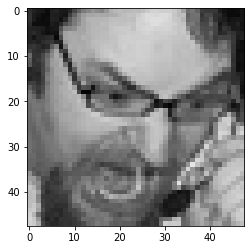

In [ ]:
from keras.preprocessing import image
img = image.load_img("../input/fer2013/test/angry/PrivateTest_10131363.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

94773248/94765736 [==============================] - 7s 0us/step


In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [ ]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

# 2. building the model

In [ ]:
# Building Model
base_model =tf.keras.applications.ResNet50()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [4]:
# Model Summary
model =tf.keras.applications.ResNet50()
model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

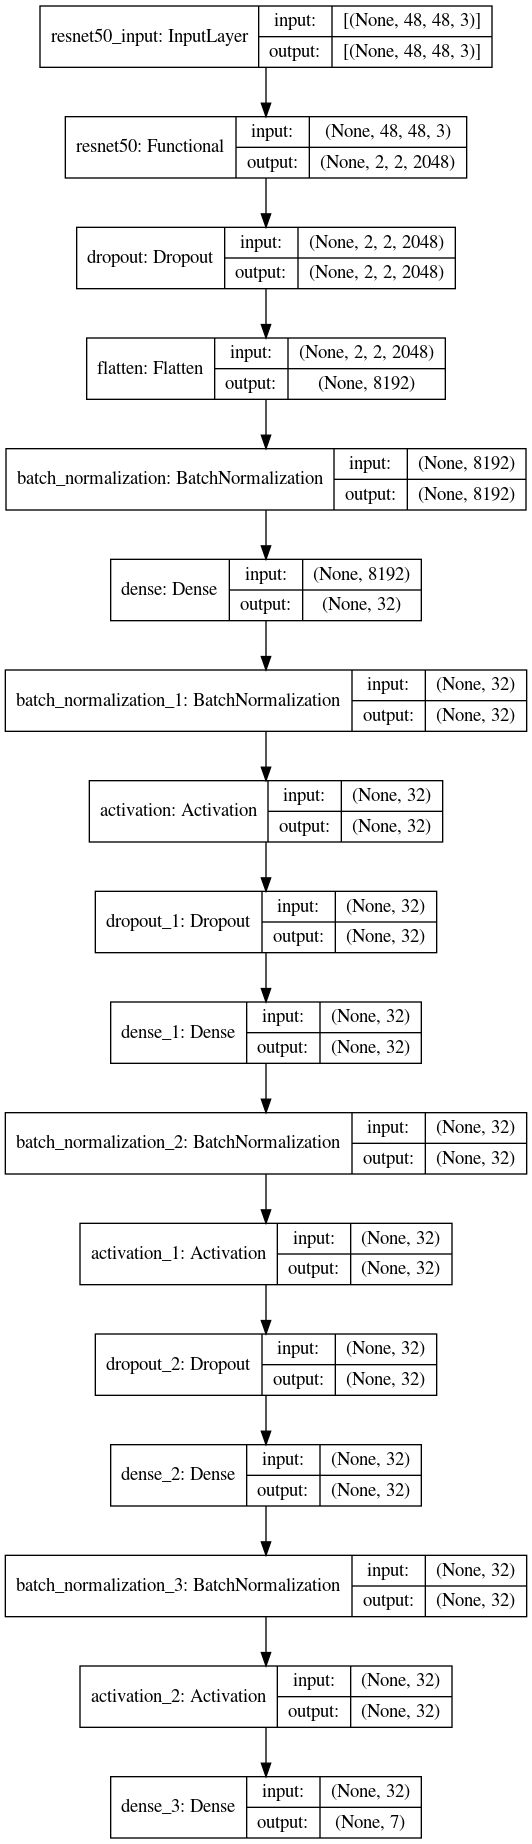

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model_details.png', show_shapes=True,show_layer_names=True)
Image(filename='model_details.png') 

## 2.2 helper functions

In [10]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [12]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model_RESNET50.h5')

es = EarlyStopping(verbose=1, patience=20)

In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# 3. Training the model

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 25,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/25
359/359 [==============================] - 193s 523ms/step - loss: 1.9382 - accuracy: 0.8542 - precision: 0.1914 - recall: 0.0066 - auc: 0.5969 - f1_score: 0.0122 - val_loss: 1.8416 - val_accuracy: 0.8572 - val_precision: 1.0000 - val_recall: 1.7419e-04 - val_auc: 0.6427 - val_f1_score: 3.4188e-04
Epoch 2/25
359/359 [==============================] - 153s 425ms/step - loss: 1.8339 - accuracy: 0.8571 - precision: 0.2839 - recall: 3.0447e-04 - auc: 0.6329 - f1_score: 5.9957e-04 - val_loss: 1.8107 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6487 - val_f1_score: 0.0000e+00
Epoch 3/25
359/359 [==============================] - 153s 425ms/step - loss: 1.8254 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6387 - f1_score: 0.0000e+00 - val_loss: 1.8063 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6540 - val_f1_score: 0.0000e+00
Epoch 4/25
359/359 [======================

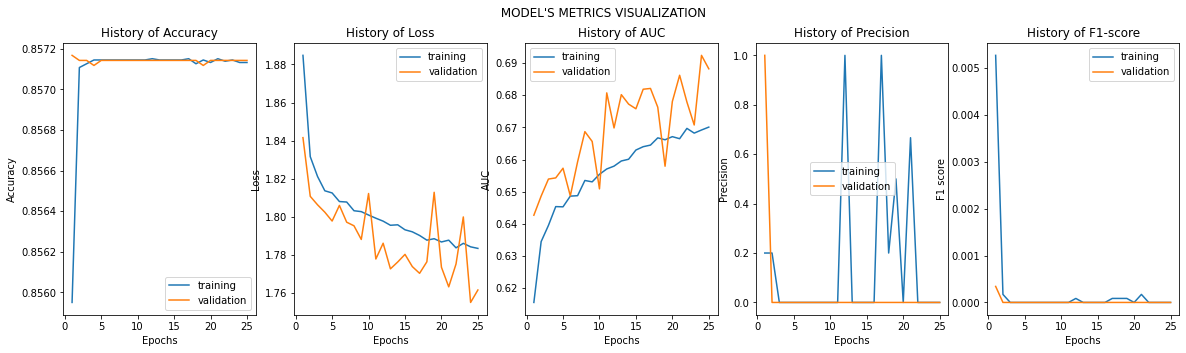

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

## Testing

In [7]:
model_test=tf.keras.models.load_model('C:/Users/Joyeeta/Desktop/ai project/')
model_test.summary() 

OSError: SavedModel file does not exist at: /final notebooks/ResNet-50.h5/{saved_model.pbtxt|saved_model.pb}

In [20]:
test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/datasets/dataset/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


In [35]:
def prepare(filepath,IMG_SIZE, face_cas="haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [44]:
def predict(image,imgsize1, prepare):
    prediction2 = model_test.predict([prepare(image,imgsize1)])

    if(np.argmax(prediction2)==0 or np.argmax(prediction2)==1):
        status2 = "Frustrated"
    elif (np.argmax(prediction2)==2 or np.argmax(prediction2)==5):
        status2 = "Confused"
    elif (np.argmax(prediction2)==3 or np.argmax(prediction2)==6):
        status2 = "Engaged"
    else:
        status2 = "Bored"
    return (status1 + " " + status2)

In [45]:
import cv2
import matplotlib.pyplot as plt

frame = cv2.imread("/content/drive/MyDrive/datasets/dataset/test/fear/PrivateTest_10153550.jpg")
predict(frame,48,prepare)
plt.imshow(frame)

SystemError: ignored